# Import and configurations

In [1]:
#from cityscapes_dataset import CityscapesDataset
from nyuv2_dataset import NYUv2Dataset
from cityscapes_dataset import CityscapesDataset
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from cross_stitchnet import CrossStitchNet
from densenet import DenseNet
from mtan import MTAN
from segnet import SegNet
from trainer import Trainer
from utils import count_params, visualize_results

from basic_modules import ConvLayer

2025-03-18 22:58:04.200800: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-18 22:58:04.240548: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-18 22:58:04.948040: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
dataset_string = 'cityscapes'
tasks = ['segmentation', 'depth'] if dataset_string == 'cityscapes' else ['segmentation', 'depth', 'normal']
depth_activation = 'sigmoid' if dataset_string == 'cityscapes' else 'relu'
BATCH_SIZE = 8 if dataset_string == 'cityscapes' else 2
LR = 1e-4

In [3]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:1


# Data Loading

In [4]:
if dataset_string == 'nyuv2':
    print("NYUv2 Dataset")
    nyuv2_train = NYUv2Dataset(root="../dataset/nyuv2_preprocessed", split='train')
    classes = nyuv2_train.get_classes()

    nyuv2_val = NYUv2Dataset(root="../dataset/nyuv2_preprocessed", split='val')
    train_dl = DataLoader(nyuv2_train, batch_size=BATCH_SIZE, shuffle=True)
    val_dl = DataLoader(nyuv2_val, batch_size=BATCH_SIZE, shuffle=False)

    for image, out in train_dl:
        print('Image: ' + str(list(image.shape)) + ',' + ' Label: ' + str(list(out['segmentation'].shape)) + ',' + ' Depth: ' + str(list(out['depth'].shape)) + ',' + ' Normals: ' + str(list(out['normal'].shape)))
        print(f'Image: {image.max().item()}, {image.min().item()}') 
        print('Label: ' +  str(out['segmentation'].max().item()) + ',' + str(out['segmentation'].min().item()))
        print('Depth: ' + str(out['depth'].max().item()) + ', ' + str(out['depth'].min().item()))
        print('Normals: ' + str(out['normal'].max().item()) + ', ' + str(out['normal'].min().item()))
        break
else:
    print("Cityscapes Dataset")
    cityscapes_train = CityscapesDataset(root="../dataset/cityscapes_preprocessed")
    cityscapes_val = CityscapesDataset(root="../dataset/cityscapes_preprocessed", split='val')
    train_dl = DataLoader(cityscapes_train, batch_size=BATCH_SIZE, shuffle=True)
    val_dl = DataLoader(cityscapes_val, batch_size=BATCH_SIZE, shuffle=False)
    classes = cityscapes_train.get_classes()
    for image, out in train_dl:
        print('Image: ' + str(list(image.shape)) + ',' + ' Label: ' + str(list(out['segmentation'].shape)) + ',' + ' Depth: ' + str(list(out['depth'].shape)))
        print(f'Image: {image.max().item()}, {image.min().item()}') 
        print('Label: ' +  str(out['segmentation'].max().item()) + ', ' + str(out['segmentation'].min().item()))
        print('Depth: ' + str(out['depth'].max().item()) + ', ' + str(out['depth'].min().item()))
        break

Cityscapes Dataset
Image: [8, 3, 128, 256], Label: [8, 128, 256], Depth: [8, 128, 256]
Image: 1.0, 0.0
Label: 6.0, -1.0
Depth: 0.4922102689743042, 0.0


# Model Training

In [5]:
# model = CrossStitchNet(classes=classes, tasks=['segmentation', 'depth', 'normal'], depth_activation='relu').to(device)
# model = MTAN(classes=classes, tasks=tasks, depth_activation=depth_activation).to(device)
# model = SegNet(classes=classes).to(device)
# print(f"{model.name} has {count_params(model)} parameters")
# opt = torch.optim.Adam(model.parameters(), lr=1e-4)
# trainer = Trainer(model, opt)
# trainer.train(train_dl, val_dl, epochs=2, save=True)

In [6]:
# opt = torch.optim.Adam(model.parameters(), lr=LR)
# trainer = Trainer(model, opt, dataset_string, device)

In [7]:
# trainer.train(train_dl, val_dl, epochs=5, save=True, check=1, grad=True)

# Model Evaluation

In [8]:
dwa_model = False
model = MTAN(classes=classes, tasks=tasks, depth_activation=depth_activation)
path = f'../models/{dataset_string}/{model.name}'
if len(model.tasks) > 1:
    path += '_dwa' if dwa_model else '_equal'
path += f'/{model.name}_5.pth'
model.load_state_dict(torch.load(path, weights_only=True))

<All keys matched successfully>

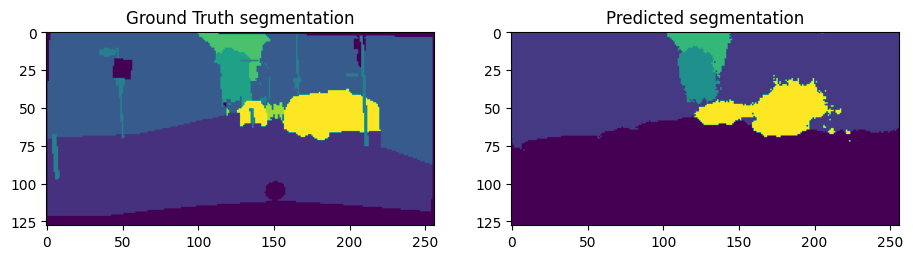

RuntimeError: one_hot is only applicable to index tensor.

<Figure size 640x480 with 0 Axes>

In [9]:
id_result = 0
for i, (image, out) in enumerate(val_dl):
    visualize_results(model, device, image, out, id_result)
    id_result += BATCH_SIZE
    break

In [ ]:
# for x, y in train_dl:
#     x = x.to(device).to(torch.float)
#     y = {k: v.to(device) for k, v in y.items()}
#     y['segmentation'] = y['segmentation'].to(torch.long)
#     y['depth'] = y['depth'].to(torch.float)
#     out = model(x)
#     print(f"Segmentation: {out['segmentation'].shape}")
#     print(f"Depth: {out['depth'].shape}")
#     print(f"Normals: {out['normal'].shape}")
#     break

In [ ]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# tests = 10
# path = 'models/mtan/mtan_train10.pth'
# model = MTAN(classes=LABELS)
# model.load_state_dict(torch.load(path, weights_only=True))
# model.to(device)
# for i, (img, img_seg, img_depth) in enumerate(val_dl):
#     visualize_results_multitask(model, img[0], img_seg[0], img_depth[0], device)
#     if i == tests:
#         break